### Итоговое задание Беломойкина Алексея по Проекту 3. О вкусной и здоровой пище (SF-DST-18)

![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import operator
from collections import Counter
import datetime as DT

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
30035,id_2844,London,"['Chinese', 'Japanese', 'Asian', 'Thai', 'Vege...",2849.0,$$ - $$$,128.0,"[['Great food, friendly service', 'Some very t...",/Restaurant_Review-g186338-d8448165-Reviews-To...,d8448165,1,4.0
21957,id_7223,Madrid,['Spanish'],7228.0,$$ - $$$,9.0,"[['Quaint restaurant', 'Wonderful coffee and c...",/Restaurant_Review-g187514-d7304438-Reviews-Vi...,d7304438,1,3.5
3667,id_3667,Dublin,"['Cafe', 'European']",573.0,$,16.0,"[['Delicious coffee with seaview', 'Out for a ...",/Restaurant_Review-g186605-d12685357-Reviews-H...,d12685357,0,0.0
26410,id_9764,Paris,NaN,9766.0,NaN,4.0,"[['Fabulous food charming service'], ['03/15/2...",/Restaurant_Review-g187147-d5965489-Reviews-Au...,d5965489,1,4.5
31659,id_1595,Hamburg,NaN,1597.0,NaN,4.0,"[['Wonderful food in a beautiful setting'], ['...",/Restaurant_Review-g187331-d1039185-Reviews-Al...,d1039185,1,4.5


In [14]:
df.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## Предобработка данных и определение базовых функций.

In [15]:

#Приведем имена столбцов к нижнему регистру, и переименуем некоторые из них

df.columns = map(str.lower, df.columns)
df.rename(columns={'cuisine style': 'cuisine_style', 'price range': 'price_range', 'number of reviews':'number_reviews'}, inplace=True)


# Функция по сбору информации по каждому столбцу

def info_column(column):
    print('Число уникальных значений:', df[column].nunique(), '\n')
    print('Число упоминания каждого значения: \n',
          df[column].value_counts(), '\n')
    print('Число пустых значений в столбце:',
          (df[column].isnull()).sum(), '\n')
    return  # df.loc[:, [column]].info()

# прорисовка гистограммы исходных данных
def hist_source_data(column):
    df[column].hist(alpha=0.4, bins=100, range=(
        start_point, end_point), label='Исходные данные {}'. format(column))
    plt.legend()
    return

## Первичный отсмотр данных

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
restaurant_id     50000 non-null object
city              50000 non-null object
cuisine_style     38410 non-null object
ranking           50000 non-null float64
price_range       32639 non-null object
number_reviews    46800 non-null float64
reviews           49998 non-null object
url_ta            50000 non-null object
id_ta             50000 non-null object
sample            50000 non-null int64
rating            50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


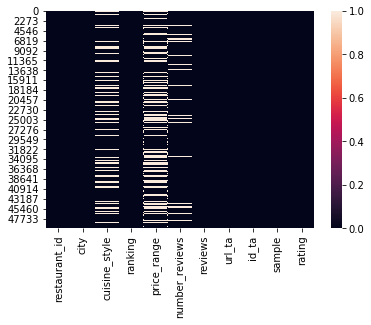

In [17]:
# построим карту пропусков данных
sns.heatmap(df.isnull(), cbar=True)

In [18]:
# описываем функцию, заменяющую в строковых столбцах  пробел на None

def clear_column(column):
    return df[column].astype(str).apply(lambda x: None if x.strip() == '' else x)

for col in df.columns:
    clear_column(col)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [19]:
# возьмем столбец Number of Reviews
df['number_reviews_isNAN'] = pd.isna(df['number_reviews']).astype('uint8')

In [20]:
# процент пропусков в столбце: 23.2%
df['cuisine_style'].isnull().value_counts(normalize=True) * 100

False    76.82
True     23.18
Name: cuisine_style, dtype: float64

In [21]:
# Пустые значения в 'cuisine_style' заменяем на ['Unknown']
df['cuisine_style'] = df['cuisine_style'].fillna("['Unknown']")

In [22]:
# процент пропусков в столбце: 34.715
df['price_range'].isnull().value_counts(normalize=True) * 100

False    65.278
True     34.722
Name: price_range, dtype: float64

In [23]:
df['price_range_isNAN'] = pd.isna(df['price_range']).astype('uint8')

In [24]:
df['reviews'] = df['reviews'].fillna('[[], []]') 
df['reviews_isNAN'] =df['reviews'].apply(lambda x: 1 if x =='[[], []]' else 0).astype('uint8')

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [25]:
df.nunique(dropna=False)

restaurant_id           13094
city                       31
cuisine_style           10732
ranking                 12975
price_range                 4
number_reviews           1574
reviews                 41857
url_ta                  49963
id_ta                   49963
sample                      2
rating                     10
number_reviews_isNAN        2
price_range_isNAN           2
reviews_isNAN               2
dtype: int64

In [26]:
df.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_reviews,reviews,url_ta,id_ta,sample,rating,number_reviews_isNAN,price_range_isNAN,reviews_isNAN
46624,id_2862,Berlin,['European'],2864.0,NaN,2.0,"[['Great place for a night out in Berlin'], ['...",/Restaurant_Review-g187323-d12925533-Reviews-B...,d12925533,1,5.0,0,1,0
7447,id_7447,Milan,['Unknown'],3142.0,NaN,11.0,"[[], []]",/Restaurant_Review-g187849-d12475373-Reviews-A...,d12475373,0,0.0,0,1,1
29276,id_4708,Paris,['Thai'],4709.0,$$ - $$$,64.0,[['Cheap Authentic Thai Eats Near the Train S....,/Restaurant_Review-g187147-d3639376-Reviews-Kh...,d3639376,1,4.0,0,0,0
28107,id_6555,Madrid,['Unknown'],6558.0,NaN,14.0,"[['Terrible service', 'Great service, breakfas...",/Restaurant_Review-g187514-d10332778-Reviews-G...,d10332778,1,3.5,0,1,0
24347,id_339,Krakow,"['Polish', 'Bar', 'European', 'Central Europea...",340.0,$$ - $$$,144.0,"[['Found it by chance.', 'Boat dining on the r...",/Restaurant_Review-g274772-d4156484-Reviews-Au...,d4156484,1,4.0,0,0,0


### 2.0. restaurant_id

In [27]:
# создадим столбец с перекодированым 'restaurant_id'
df['code_restaurant_id'] = df['restaurant_id'].apply(lambda x: int(x[3:]))

### 2.1. city

In [28]:
info_column('city')

Число уникальных значений: 31 

Число упоминания каждого значения: 
 London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: city, dtype: int64 

Число пустых значений в столбце: 0 



In [29]:
df.city.unique()

array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

In [30]:
# Создаем эталонную таблицу с эталонными  значениями некоторых столбцов для каждого 'city'
reference_table = pd.DataFrame(df.city.unique(), columns = ['city'])

### 2.2. cuisine_style

In [31]:
info_column('cuisine_style')

Число уникальных значений: 10732 

Число упоминания каждого значения: 
 ['Unknown']                                                                                             11590
['Italian']                                                                                              1332
['French']                                                                                               1019
['Spanish']                                                                                               860
['French', 'European']                                                                                    503
                                                                                                        ...  
['Barbecue', 'Asian', 'Korean', 'Gluten Free Options']                                                      1
['Cafe', 'European', 'Danish', 'Central European', 'Vegetarian Friendly']                                   1
['Indian', 'Asian', 'Balti', 'Halal', 'Vegetaria

In [32]:
df['cuisine_style'].value_counts()[:10]

['Unknown']                   11590
['Italian']                    1332
['French']                     1019
['Spanish']                     860
['French', 'European']          503
['Cafe']                        500
['Pizza']                       454
['Italian', 'Pizza']            422
['Chinese']                     418
['European', 'Portuguese']      415
Name: cuisine_style, dtype: int64

In [33]:
# Создадим столбец со списками кухонь
df['cuisines'] = df['cuisine_style'].str.findall(r"'(\b.*?\b)'") 

In [34]:
# Создадим список списков всех кухонь и подсчитываем количество упоминаний каждой кухни
cuis_list = df['cuisines'].tolist()


def find_list_cuisines(list_of_lists):
    result = []
    for lst in list_of_lists:
        result.extend(lst)
    return result


cuisines_counter = Counter(find_list_cuisines(cuis_list))
cuisines_counter.most_common()

[('Vegetarian Friendly', 14021),
 ('European', 12561),
 ('Unknown', 11590),
 ('Mediterranean', 7820),
 ('Italian', 7433),
 ('Vegan Options', 5684),
 ('Gluten Free Options', 5185),
 ('Bar', 4094),
 ('French', 3970),
 ('Asian', 3786),
 ('Pizza', 3502),
 ('Spanish', 3456),
 ('Pub', 3058),
 ('Cafe', 2883),
 ('Fast Food', 2122),
 ('British', 1992),
 ('International', 1966),
 ('Seafood', 1878),
 ('Japanese', 1860),
 ('Central European', 1727),
 ('American', 1642),
 ('Sushi', 1450),
 ('Chinese', 1446),
 ('Portuguese', 1385),
 ('Indian', 1328),
 ('Middle Eastern', 980),
 ('Thai', 923),
 ('Wine Bar', 877),
 ('German', 820),
 ('Halal', 773),
 ('Greek', 768),
 ('Healthy', 758),
 ('Fusion', 748),
 ('Czech', 745),
 ('Steakhouse', 729),
 ('Barbecue', 710),
 ('Contemporary', 652),
 ('Soups', 630),
 ('Eastern European', 629),
 ('Vietnamese', 622),
 ('Grill', 617),
 ('Gastropub', 608),
 ('Turkish', 574),
 ('Mexican', 572),
 ('South American', 490),
 ('Delicatessen', 473),
 ('Austrian', 462),
 ('Polish'

### 2.3. ranking

In [35]:
info_column('ranking')

Число уникальных значений: 12975 

Число упоминания каждого значения: 
 93.0       22
72.0       21
491.0      21
842.0      21
1013.0     20
           ..
8027.0      1
10415.0     1
14621.0     1
11766.0     1
10585.0     1
Name: ranking, Length: 12975, dtype: int64 

Число пустых значений в столбце: 0 



### 2.4. rating

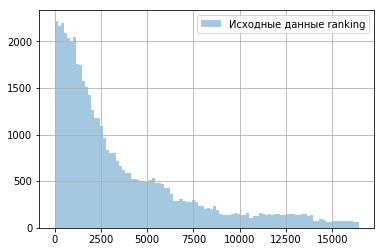

In [36]:
start_point = df['ranking'].min()
end_point = df['ranking'].max()
hist_source_data('ranking')
#Распределение нормальное. Выбросов и пропусков нет 

### 2.4 . rating

In [37]:
info_column('rating')

Число уникальных значений: 10 

Число упоминания каждого значения: 
 4.0    13692
4.5    10929
0.0    10000
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: rating, dtype: int64 

Число пустых значений в столбце: 0 



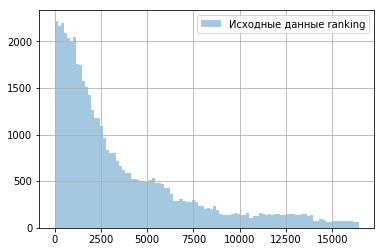

In [38]:
start_point = df['ranking'].min()
end_point = df['ranking'].max()
hist_source_data('ranking')
#Распределение нормальное. Выбросов и пропусков нет 

### 2.5. price_range

In [39]:
info_column('price_range')

Число уникальных значений: 3 

Число упоминания каждого значения: 
 $$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64 

Число пустых значений в столбце: 17361 



In [40]:
# процент пропусков в столбце: 34.722
df['price_range'].isnull().value_counts(normalize=True) * 100

False    65.278
True     34.722
Name: price_range, dtype: float64

In [41]:
#  Заполним пропуски пробелами
df['price_range'].fillna('',inplace = True)

In [42]:
# Создаем в эталонной таблице столбец 'range_of_price' с модой диапазона  непустых цен для каждого 'city'

def find_price_mode(row):
    return df[(df['city'] == row['city']) & (df['price_range']!='')]['price_range'].mode()[0]


reference_table['range_of_price'] = reference_table.apply(find_price_mode, axis=1)

In [43]:
reference_table['range_of_price'].value_counts()

$$ - $$$    31
Name: range_of_price, dtype: int64

In [44]:
# Пустым значениям в df['price_range'] присваиваем значение из эталонной таблицы в соответствии с 'city' 
def insert_range_of_price(row):
    if row['price_range'] == '': 
        return str(reference_table[reference_table['city'] == row['city']]['range_of_price'].values)[2:-2]
    return row['price_range']


df['price_range'] = df.apply(insert_range_of_price, axis=1)

In [45]:
df['price_range'].value_counts()

$$ - $$$    40402
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [46]:
#Перекодируем  'price_range' в цифры и создадим новый столбец 'сode_price_range':
def code_price_range (row):
    if row['price_range'] == '$':
        return 1
    if row['price_range'] == '$$ - $$$':
        return 2
    return 3
df['code_price_range'] = df.apply(code_price_range, axis=1)

### 2.6. number_reviews

In [47]:
info_column('number_reviews')

Число уникальных значений: 1573 

Число упоминания каждого значения: 
 2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: number_reviews, Length: 1573, dtype: int64 

Число пустых значений в столбце: 3200 



In [48]:
# для начала заполним пропуски в 'number_reviews' 0, чтобы не вылетали последующие функции
df['number_reviews'].fillna(0,inplace = True)

In [49]:
# Создаем в эталонной таблице столбец 'number_reviews' с модой количества отзывов для каждого 'city'

def find_number_reviews_mode(row):
    return df[df['city'] == row['city']]['number_reviews'].mode()[0]


reference_table['number_reviews'] = reference_table.apply(find_number_reviews_mode, axis=1)

In [50]:

# нулевым значениям в df[number_reviews'] присваиваем значение из эталонной таблицы в соответствии с 'city' 
def insert_number_reviews(row):
    if row['number_reviews'] == 0: 
        return str(reference_table[reference_table['city'] == row['city']]['number_reviews'].values)[2:-2]
    return row['number_reviews']


df['last_review_date'] = df.apply(insert_number_reviews, axis=1)

### 2.7. reviews

In [51]:
info_column('reviews')

Число уникальных значений: 41857 

Число упоминания каждого значения: 
 [[], []]                                                                                                                              8114
[['Whenever in Madrid, we never miss this gem...', 'Underrated sushi restaurant with very good...'], ['04/11/2017', '12/02/2016']]       2
[['Delicious'], ['06/06/2017']]                                                                                                          2
[['Great Asian Option', 'Wow'], ['10/16/2017', '09/07/2016']]                                                                            2
[['Fantastic food, Excellent service', 'Surprising good Indian food in Spain'], ['01/07/2018', '11/08/2017']]                            2
                                                                                                                                      ... 
[['Exellent', 'Team meeting'], ['09/23/2015', '05/20/2015']]                                  

In [52]:
#Создаем столбец 'last_review_date' с датами отзывов
df['last_review_date'] = df['reviews'].str.findall('\d+/\d+/\d\d\d\d')

In [53]:
# оставляем в 'last_review_date' дату последнего отзыва
# Если ее нет ставим None  
def date_last_review (row):
    if row['last_review_date'] == []:
        return None
    return max(row['last_review_date'])
df['last_review_date'] = df.apply(date_last_review, axis=1)

In [54]:
# Переводим столбец df['last_review_date'] в формат DateTime
df['last_review_date'] = pd.to_datetime(df['last_review_date'])
# находим самую раннюю дату
oldest_date =df[df['last_review_date']!=None]['last_review_date'].min()
print(oldest_date)
# заполняем ею пропуски
df['last_review_date'].fillna(oldest_date,inplace=True)

2004-04-21 00:00:00


In [55]:
df['last_review_date'].unique()

array(['2004-04-21T00:00:00.000000000', '2017-12-05T00:00:00.000000000',
       '2017-12-28T00:00:00.000000000', ...,
       '2012-08-10T00:00:00.000000000', '2012-04-11T00:00:00.000000000',
       '2012-07-04T00:00:00.000000000'], dtype='datetime64[ns]')

### 2.8. URL_TA

In [56]:
info_column('url_ta')

Число уникальных значений: 49963 

Число упоминания каждого значения: 
 /Restaurant_Review-g187514-d5618007-Reviews-Juanyta_ME_MATA-Madrid.html                             2
/Restaurant_Review-g187514-d1235635-Reviews-Restaurante_Arroceria_Puerta_de_Atocha-Madrid.html      2
/Restaurant_Review-g187514-d7342803-Reviews-Los_Hierros-Madrid.html                                 2
/Restaurant_Review-g187514-d3161682-Reviews-Cerveceria_La_Surena-Madrid.html                        2
/Restaurant_Review-g187514-d11999956-Reviews-SugarCane_Madrid-Madrid.html                           2
                                                                                                   ..
/Restaurant_Review-g186338-d731427-Reviews-Anarkali-London_England.html                             1
/Restaurant_Review-g4049419-d4374574-Reviews-Ferry_Tap-South_Queensferry_Edinburgh_Scotland.html    1
/Restaurant_Review-g187147-d3682215-Reviews-L_Avant_Scene-Paris_Ile_de_France.html                  1
/Restauran

In [57]:
df['code_url_ta']= df['url_ta'].str.split('-').apply(lambda x: x[1][1:]).astype('int64')

### 2.9. ID_TA

In [58]:
info_column('id_ta')

Число уникальных значений: 49963 

Число упоминания каждого значения: 
 d7342803     2
d2477531     2
d7809594     2
d2669414     2
d10316215    2
            ..
d4150215     1
d2296422     1
d1024682     1
d7971932     1
d7714322     1
Name: id_ta, Length: 49963, dtype: int64 

Число пустых значений в столбце: 0 



In [59]:
df['code_id_ta']= df['id_ta'].apply(lambda x: x[1:]).astype('int64')

## Создание дополнительных признаков

In [60]:
# Создаем признак является ли ресторан сетевым, т.е. встречается ли его id более одного раза
a = df.id_ta.value_counts()
df['chain_restaurant'] = df.id_ta.apply(
    lambda x: 1 if a[x] > 1 else 0).astype('uint8')
df['chain_restaurant'].value_counts()

0    49926
1       74
Name: chain_restaurant, dtype: int64

In [61]:
# Создаем список столиц
capital_list = ['Paris', 'Stockholm', 'London', 'Berlin', 'Bratislava', 'Vienna',
                'Rome', 'Madrid', 'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen', 'Amsterdam',
                'Lisbon', 'Prague', 'Oslo', 'Helsinki', 'Edinburgh', 'Ljubljana', 'Athens',  'Luxembourg']
cities_nord_europe = ['Stockholm', 'London', 'Dublin', 'Copenhagen', 'Amsterdam', 'Oslo',
                      'Helsinki', 'Edinburgh']
cities_central_europe = ['Paris', 'Berlin', 'Munich', 'Bratislava', 'Vienna',  'Brussels',
                         'Zurich', 'Warsaw', 'Budapest', 'Hamburg', 'Prague', 'Geneva',
                         'Ljubljana', 'Luxembourg', 'Krakow', 'Ljubljana']
cities_south_europe = ['Oporto',  'Milan', 'Rome',
                       'Barcelona', 'Madrid', 'Lyon', 'Lisbon', 'Geneva']

In [62]:
# создаем признак нахождения ресторана в столице
def find_capital_city (row):
    if row['city'] in capital_list:
        return 1
    return 0
df['capital_city'] = df.apply(find_capital_city, axis=1).astype('uint8')


# создаем признак нахождения ресторана в северной Европе
def find_nord_europe (row):
    if row['city'] in cities_nord_europe:
        return 1
    return 0
df['nord_europe'] = df.apply(find_nord_europe , axis=1).astype('uint8')

# создаем признак нахождения ресторана в центральной Европе
def find_central_europe (row):
    if row['city'] in cities_central_europe:
        return 1
    return 0
df['central_europe'] = df.apply(find_central_europe , axis=1).astype('uint8')

# создаем признак нахождения ресторана в южной Европе
def find_south_europe (row):
    if row['city'] in cities_south_europe:
        return 1
    return 0
df['south_europe'] = df.apply(find_south_europe , axis=1).astype('uint8')

# Создадим признак, явдяется ли город морским портом
seaport_list = ['Stockholm', 'London', 'Barcelona', 'Dublin', 'Copenhagen', 'Amsterdam', 
'Hamburg', 'Lisbon', 'Oslo',  'Helsinki', 'Edinburgh', 'Athens']

df['seaport'] = df['city'].apply(lambda x: 1 if x in seaport_list else 0).astype('uint8')

#Создание столбцов с дополнительными признаками городов
for item in list(df.city.unique()):
    df[item] = df.city.apply(lambda x: 1 if x==item else 0)
#df = pd.get_dummies(df, columns=['city'], dummy_na=False)

In [63]:
# Создаем признак количества кухонь в ресторане
df['count_cuisines'] = df['cuisines'].apply(lambda x: len(x))

In [64]:
# Cоздадим столбец присутствия редких кухонь (менее 20 на 40000 ресторанов)
rare_cuisine_list = [x[0] for x in cuisines_counter.most_common()[-27:]]

for cuisine in rare_cuisine_list:
    df['rare_cuisine'] = df['cuisines'].apply(lambda x: 1 if cuisine in x else 0).astype('uint8')

In [65]:
# Cоздадим столбец присутствия 100 популярных кухонь
popular_cuisine_list = [x[0] for x in cuisines_counter.most_common()[:50]]

for cuisine in popular_cuisine_list:
    df['popular_cuisine'] = df['cuisines'].apply(lambda x: 1 if cuisine in x else 0).astype('uint8')

In [66]:
# Cоздадим столбец нечасто встречающися кухонь
infrequent_cuisine_list = [x[0] for x in cuisines_counter.most_common()[50:-26]]

for cuisine in infrequent_cuisine_list:
    df['infrequent_cuisine'] = df['cuisines'].apply(lambda x: 1 if cuisine in x else 0).astype('uint8')

In [67]:
# Создадим списки с положительными и негативными словами из отзывов:

good_words_list =['Good', ' good', ' excellent', 'fantast', 'Fantast', 'Excellent', 'Fine', ' fine', 
                  'Better', ' better', 'Delicious', ' delicious' 'Nice', 'nice', ' tasty', 'Tasty', 
                  'Worthy', 'worthy', ' friendly', 'Friendly' ' best', 'Best', ' cozy', 'Cozy', 
                  'Magnifi', ' magnifi', 'Elegant', ' elegant']

bad_words_list =['Bad', 'bad', ' ugly', 'Ugly', ' slow', 'Slow', 'Nightmare', ' nightmare', ' lazy', 'Lazy', 
           ' expensive', 'Expensive', ' worst', 'Worst']

# Создадим признаки наличия хороших и плохих отзывов
df['good_reviews'] = df['reviews'].apply(lambda x: 1 if any(word in x for word in good_words_list) else 0).astype('uint8')


df['bad_reviews'] = df['reviews'].apply(lambda x: 1 if any(word in x for word in bad_words_list) else 0).astype('uint8')

In [68]:
# Создаем столбец с Timedelta с момента последнего отзыва
df['days_from_review'] = DT.datetime.today() - df['last_review_date']
# и преобразуем его в количество дней
df['days_from_review'] = df['days_from_review'].map(lambda x: x.days)

In [69]:
# Создадим признак с величиной населения городов
population_dict = {'Paris': 2140526, 'Stockholm': 961609, 'London': 8787892, 'Berlin': 3601131, 'Munich': 1456039, 'Oporto': 221800,
       'Milan': 1366180, 'Bratislava': 437725, 'Vienna': 1840573, 'Rome':2872800, 'Barcelona':  1620343, 'Madrid': 3223334,
       'Dublin' : 553165, 'Brussels' : 1198726, 'Zurich' : 434008, 'Warsaw' : 1702139, 'Budapest' : 1752286, 'Copenhagen' : 615993,
       'Amsterdam' : 859732, 'Lyon' : 515695, 'Hamburg' : 1830584, 'Lisbon': 553000, 'Prague' : 1280508, 'Oslo' : 673469,
       'Helsinki' : 643272, 'Edinburgh': 513210 , 'Geneva': 201818, 'Ljubljana' : 284355, 'Athens' : 655780,
       'Luxembourg' : 122273, 'Krakow' : 779115}

df['population'] = df['city'].apply(lambda x: population_dict[x])

In [70]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 65 columns):
restaurant_id           50000 non-null object
city                    50000 non-null object
cuisine_style           50000 non-null object
ranking                 50000 non-null float64
price_range             50000 non-null object
number_reviews          50000 non-null float64
reviews                 50000 non-null object
url_ta                  50000 non-null object
id_ta                   50000 non-null object
sample                  50000 non-null int64
rating                  50000 non-null float64
number_reviews_isNAN    50000 non-null uint8
price_range_isNAN       50000 non-null uint8
reviews_isNAN           50000 non-null uint8
code_restaurant_id      50000 non-null int64
cuisines                50000 non-null object
code_price_range        50000 non-null int64
last_review_date        50000 non-null datetime64[ns]
code_url_ta             50000 non-null int64
code_id_ta   

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

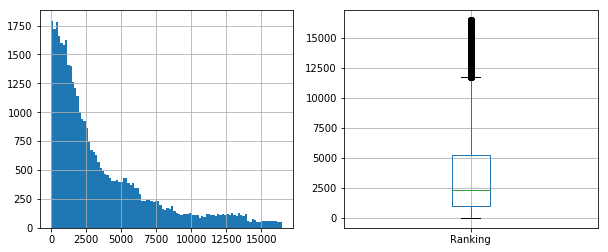

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4));
df_train['Ranking'].hist(bins=100, ax=axes[0])
df_train.boxplot(column='Ranking', ax=axes[1])

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

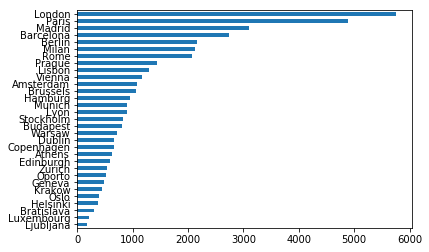

In [72]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

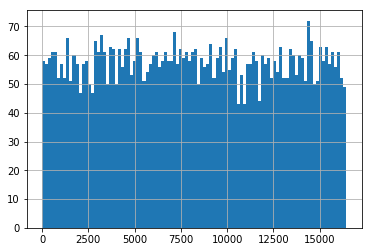

In [73]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

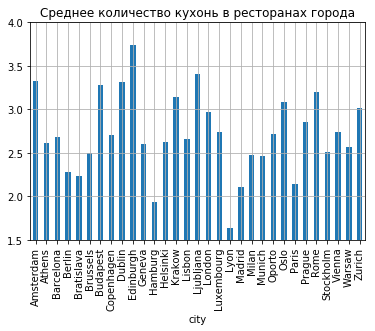

In [74]:
df.groupby(['city'])['count_cuisines'].mean().plot(kind='bar', ylim=(1.5, 4), grid=True, title='Среднее количество кухонь в ресторанах города')

In [75]:
# Сформируем новый признак - среднее число кухонь для города (<2, 2<=x<3,>=3):
mean_cuisines_list =dict(round(df.groupby(['city'])['count_cuisines'].mean(),2))

df['mean_cuisines<2'] = df.city.apply(lambda x: 1 if mean_cuisines_list[x]<2 else 0)
df['2<=mean_cuisines<3'] = df.city.apply(lambda x: 1 if 2<=mean_cuisines_list[x]<3 else 0)
df['mean_cuisines>=3'] = df.city.apply(lambda x: 1 if mean_cuisines_list[x]>=3 else 0)

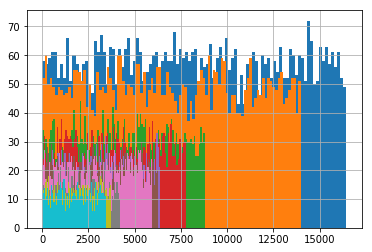

In [76]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

### Посмотрим распределение целевой переменной

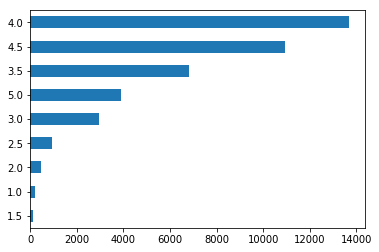

In [77]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

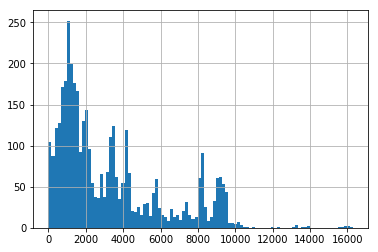

In [78]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

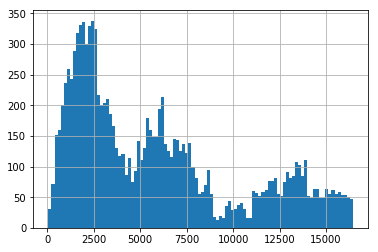

In [79]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### [Корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике можно видеть, как признаки связаны между собой и с целевой переменной.

In [80]:
df.columns

Index(['restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range',
       'number_reviews', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating',
       'number_reviews_isNAN', 'price_range_isNAN', 'reviews_isNAN',
       'code_restaurant_id', 'cuisines', 'code_price_range',
       'last_review_date', 'code_url_ta', 'code_id_ta', 'chain_restaurant',
       'capital_city', 'nord_europe', 'central_europe', 'south_europe',
       'seaport', 'Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava',
       'Lisbon', 'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid', 'Oslo',
       'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw', 'Oporto', 'Krakow',
       'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva', 'Ljubljana',
       'count_cuisines', 'rare_cuisine', 'popular_cuisine',
       'infrequent_cuisine', 'good_reviews', 'bad_reviews', 'days_from_review',
       'population', 'mean_cuisines<2', '2<=mean_c

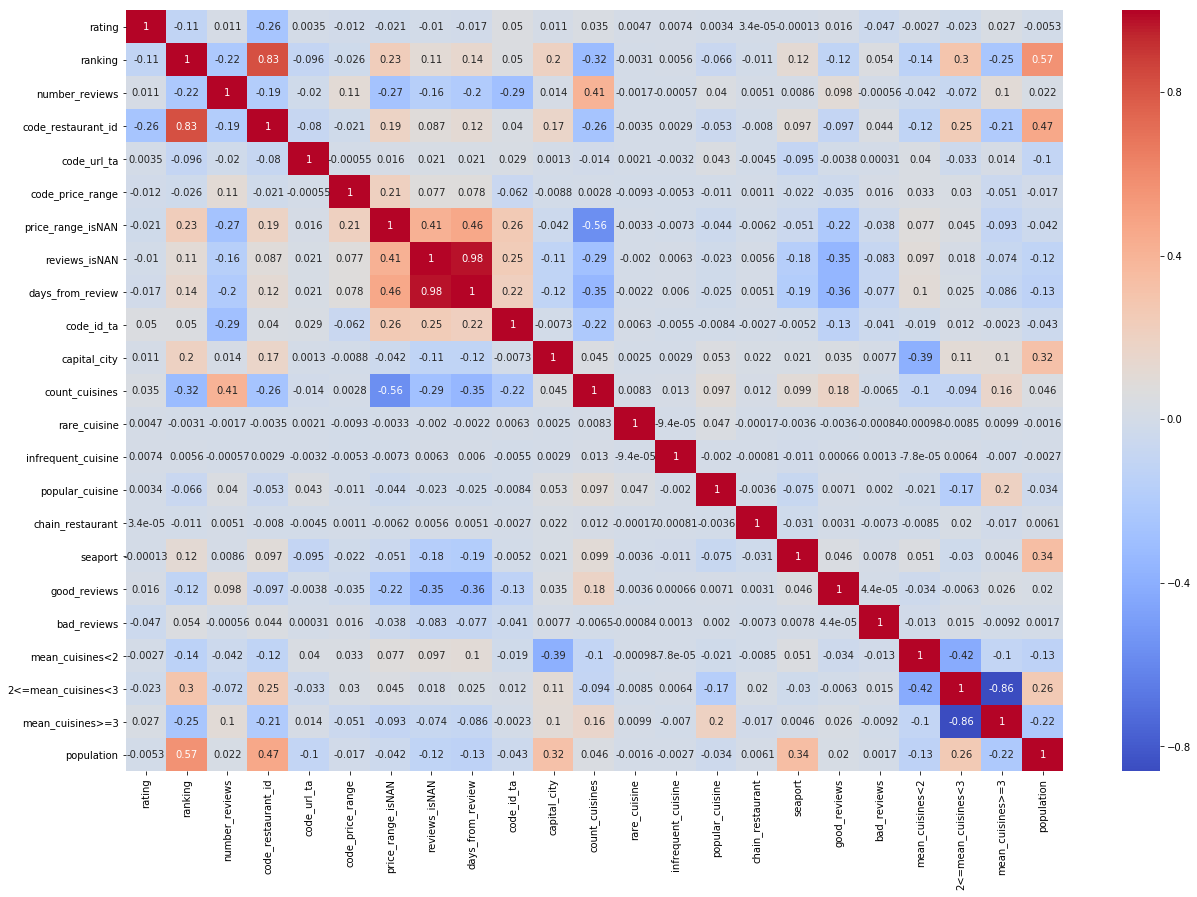

In [81]:
# Создаем датафрейм с основными числовыми признаками и смотрим их корреляцию
df_base = df[['rating','ranking', 'number_reviews', 'code_restaurant_id', 'code_url_ta', 'code_price_range', 'price_range_isNAN', 'reviews_isNAN', 'days_from_review', 
              'code_id_ta', 'capital_city', 'count_cuisines', 'rare_cuisine','infrequent_cuisine', 'popular_cuisine', 'chain_restaurant', 'seaport', 
              'good_reviews', 'bad_reviews', 'mean_cuisines<2','2<=mean_cuisines<3','mean_cuisines>=3', 'population' ]] 

correlation = df_base.corr()
plt.figure(figsize=(21, 14))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

# Data Preprocessing

In [82]:
#Неактивированная функция
#Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.


# на всякий случай, заново подгружаем данные
#df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
#df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
#df_train['sample'] = 1 # помечаем где у нас трейн
#df_test['sample'] = 0 # помечаем где у нас тест
#df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

#data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
#data.info()

def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

#df_preproc = preproc_data(data)

In [83]:
# Создаем датафрейм с числовыми столбцами исходного датафрейма
df_preproc = df.select_dtypes(include = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8'])

In [84]:
# У 'ranking' и 'code_restaurant_id' одинаковая корреляция со всеми столбцами, поэтому удалим 'code_restaurant_id'
df_preproc.drop(['code_restaurant_id'], axis = 1,inplace=True, errors='ignore')
# Из-за низкой кореляции с целевой переменной удаляем признаки морского порта и характеристики отзывов:
df_preproc.drop([ 'seaport', 'good_reviews', 'bad_reviews', 'code_id_ta'], axis = 1,inplace=True, errors='ignore')
df_preproc.sample(10)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ranking,number_reviews,sample,rating,number_reviews_isNAN,price_range_isNAN,reviews_isNAN,code_price_range,code_url_ta,chain_restaurant,...,Ljubljana,count_cuisines,rare_cuisine,popular_cuisine,infrequent_cuisine,days_from_review,population,mean_cuisines<2,2<=mean_cuisines<3,mean_cuisines>=3
40597,417.0,21.0,1,4.5,0,0,0,1,274772,0,...,0,2,0,0,0,1591,779115,0,0,1
3627,5274.0,94.0,0,0.0,0,0,0,2,187849,0,...,0,2,0,0,0,1116,1366180,0,1,0
33012,8865.0,155.0,1,4.0,0,0,0,2,186338,0,...,0,5,0,0,0,1215,8787892,0,1,0
48258,949.0,17.0,1,4.5,0,1,0,2,187265,0,...,0,1,0,0,0,1541,515695,1,0,0
11509,10398.0,83.0,1,3.5,0,0,0,1,186338,0,...,0,3,0,0,0,1148,8787892,0,1,0
24606,1025.0,1651.0,1,4.0,0,0,0,2,187791,0,...,0,6,0,0,0,1034,2872800,0,0,1
37706,7022.0,5.0,1,2.5,0,0,1,2,187497,0,...,0,1,0,0,0,5995,1620343,0,1,0
41023,80.0,597.0,1,4.5,0,0,0,1,187323,0,...,0,4,0,0,0,1013,3601131,0,1,0
45508,876.0,30.0,1,4.5,0,0,0,2,187265,0,...,0,1,0,0,0,1634,515695,1,0,0
30375,53.0,142.0,1,4.5,0,0,0,3,189934,0,...,0,5,0,0,0,990,643272,0,1,0


#### Запускаем и проверяем что получилось

In [85]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 54 columns):
ranking                 50000 non-null float64
number_reviews          50000 non-null float64
sample                  50000 non-null int64
rating                  50000 non-null float64
number_reviews_isNAN    50000 non-null uint8
price_range_isNAN       50000 non-null uint8
reviews_isNAN           50000 non-null uint8
code_price_range        50000 non-null int64
code_url_ta             50000 non-null int64
chain_restaurant        50000 non-null uint8
capital_city            50000 non-null uint8
nord_europe             50000 non-null uint8
central_europe          50000 non-null uint8
south_europe            50000 non-null uint8
Paris                   50000 non-null int64
Helsinki                50000 non-null int64
Edinburgh               50000 non-null int64
London                  50000 non-null int64
Bratislava              50000 non-null int64
Lisbon                  50000 

In [86]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [87]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [88]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 53), (40000, 53), (40000, 52), (32000, 52), (8000, 52))

# Model 
Сам ML

In [89]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [90]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [91]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [92]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20421437500000003


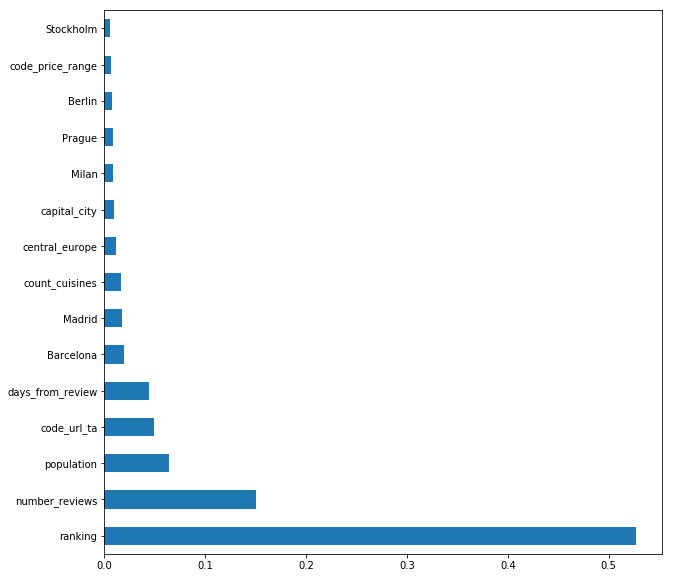

In [93]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраивает - готовим Submission на кагл

In [94]:
test_data.sample(10)

,ranking,number_reviews,rating,number_reviews_isNAN,price_range_isNAN,reviews_isNAN,code_price_range,code_url_ta,chain_restaurant,capital_city,...,Ljubljana,count_cuisines,rare_cuisine,popular_cuisine,infrequent_cuisine,days_from_review,population,mean_cuisines<2,2<=mean_cuisines<3,mean_cuisines>=3
4948,3567.0,147.0,0.0,0,0,0,2,186338,0,1,...,0,4,0,0,0,1018,8787892,0,1,0
2514,609.0,39.0,0.0,0,0,0,1,189400,0,1,...,0,2,0,0,0,1476,655780,0,1,0
9230,3111.0,3.0,0.0,0,1,0,2,190454,0,1,...,0,1,0,0,0,1343,1840573,0,1,0
7984,9323.0,4.0,0.0,0,1,0,2,187147,0,1,...,0,1,0,0,0,1731,2140526,0,1,0
5953,6238.0,4.0,0.0,0,1,0,2,187323,0,1,...,0,1,0,0,0,2942,3601131,0,1,0
5120,3662.0,276.0,0.0,0,0,0,2,187147,0,1,...,0,2,0,0,0,1093,2140526,0,1,0
9622,651.0,212.0,0.0,0,0,0,2,186525,0,1,...,0,3,0,0,0,1073,513210,0,0,1
3368,2929.0,40.0,0.0,0,0,0,2,187497,0,0,...,0,3,0,0,0,1171,1620343,0,1,0
929,2204.0,0.0,0.0,1,1,0,2,189852,0,1,...,0,2,0,0,0,2392,961609,0,1,0
6445,6840.0,13.0,0.0,0,0,0,1,186338,0,1,...,0,2,0,0,0,1221,8787892,0,1,0


In [95]:
test_data = test_data.drop(['rating'], axis=1)

In [96]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [97]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [98]:
predict_submission

array([3.05 , 4.325, 4.52 , ..., 3.01 , 4.485, 4.345])

In [99]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.050
1,id_1,4.325
2,id_2,4.520
3,id_3,4.200
4,id_4,4.490
5,id_5,4.465
6,id_6,2.030
7,id_7,2.975
8,id_8,4.415
9,id_9,4.670
